In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import binary_crossentropy

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras import optimizers

import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [ ]:
import plotly
from plotly import graph_objects as go
from plotly import express as px
from plotly.subplots import make_subplots

In [ ]:
!pip install transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
from textblob import TextBlob


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 120 kB 49.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.4 MB/s 


In [ ]:
# Bitcoin
url = 'https://drive.google.com/file/d/1LUeaWYPPD2g8tAXjRIP3x1OSzOaxmov-/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
bitcoin = pd.read_csv(path)

#Binance
url='https://drive.google.com/file/d/1mxBa0zTcFMarXxq9maGuCA2xDuBp9dep/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
binance=pd.read_csv(path)

#Cosmos
url='https://drive.google.com/file/d/1tW_ShljB9dFLciW8wGSzLiWM6WetHa1N/view?usp=sharing'
path='https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
cosmos=pd.read_csv(path)

#Ethereum
url='https://drive.google.com/file/d/1dlfrM2wibvZx_NUMjbNIHTLd7fUyN6Wb/view?usp=sharing'
path='https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
ethereum=pd.read_csv(path)

#Solana
url='https://drive.google.com/file/d/1Zb8EUpxiZ6bNeuBEJ-_WQoIQnhJEdF1K/view?usp=sharing'
path='https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
solana=pd.read_csv(path)





In [ ]:
#Data cleaning
# set date as index
ethereum = ethereum.set_index(['Date'])
# drop unnecessary columns
ethereum = ethereum.drop(['SNo', 'Name', 'Symbol'], 1)
# convert dates from string to datetime
ethereum.index = pd.to_datetime(ethereum.index)
# filter dates to align with sentiment data
ethereum = ethereum.loc[:'2019-12-31']
ethereum

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,
2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,6.741880e+05,4.548689e+07
2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,5.321700e+05,4.239957e+07
2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,4.052830e+05,4.281836e+07
2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,1.463100e+06,6.456929e+07
2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,2.150620e+06,7.364501e+07
...,...,...,...,...,...,...
2019-12-27 23:59:59,128.097571,124.820811,126.368795,127.214611,8.299390e+09,1.387305e+10
2019-12-28 23:59:59,130.258169,126.899697,127.213015,128.322712,8.069299e+09,1.399523e+10
2019-12-29 23:59:59,136.811197,127.997656,128.266871,134.757985,9.708777e+09,1.469848e+10


In [ ]:
def show_history(coin_name):
    high = coin_name['High']
    low = coin_name['Low']
    open = coin_name['Open']
    close = coin_name['Close']
    fig = px.line(coin_name, x= coin_name.index, y =[high, low, open, close], labels={'Date': 'Date','value':'Price'})
    fig.update_layout(title_text= "Ethereum History", font_size=15, font_color='Blue',legend_title_text='Parameters')
    fig.show()

In [ ]:
show_history(ethereum)

In [ ]:
#LSTM
#Train_test split
target_col = "Close"

In [ ]:
def train_test_split(df, test_size = 0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(ethereum, test_size = 0.2)


In [ ]:
print("Length train: ", len(train))
print("Length test: ", len(test))

Length train:  1286
Length test:  321


In [ ]:
def line_plot(line1, line2, label1 = None, label2 = None, title = '', lw = 2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw, color = '#f2a900')
    ax.plot(line2, label=label2, linewidth=lw, color = '#4d4d4e')
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16, weight = 'bold')
    ax.legend(loc='best', fontsize=16)

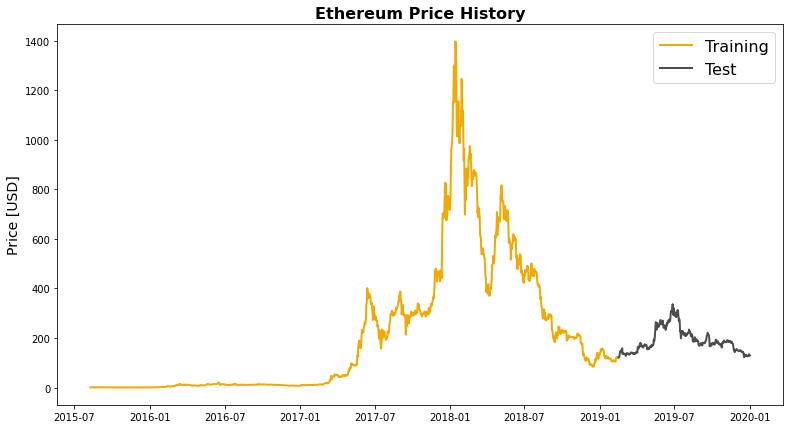

In [ ]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='Ethereum Price History')

In [ ]:
#Model development
# normalization (changing numeric values to common scale)
# does not distort difference in the range of the values

normalize = ['High', 'Low', 'Open', 'Close', 'Marketcap']

def normalize_zero_base(df):
    return df[normalize] / df[normalize].iloc[0] - 1

In [ ]:
# extract data in windows (number of previous days)

def extract_window_data(df, window_len = 5, zero_base = True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalize_zero_base(tmp)
        window_data.append(tmp.values)
        
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [ ]:
def window_model(windowsize = None):
    
    np.random.seed(42)
    window_len = windowsize
    test_size = 0.2
    zero_base = True
    lstm_neurons = 100
    epochs = 10
    batch_size = 32
    loss = 'mse'
    dropout = 0.2
    optimizer = "adam"
    
    train, test, X_train, X_test, y_train, y_test = prepare_data(
    bitcoin, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
    
    model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
    history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
    
    targets = test[target_col][window_len:]
    preds = model.predict(X_test).squeeze()
    return mean_absolute_error(preds, y_test)

In [ ]:
#5 Days Model
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 9
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = "adam"


In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    ethereum, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
X_train.shape

(1281, 5, 5)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/9
41/41 [==============================] - 2s 7ms/step - loss: 0.0201
Epoch 2/9
41/41 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 3/9
41/41 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 4/9
41/41 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 5/9
41/41 [==============================] - 0s 6ms/step - loss: 0.0082
Epoch 6/9
41/41 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 7/9
41/41 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 8/9
41/41 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 9/9
41/41 [==============================] - 0s 6ms/step - loss: 0.0071


Text(0.5, 0, 'Epoch')

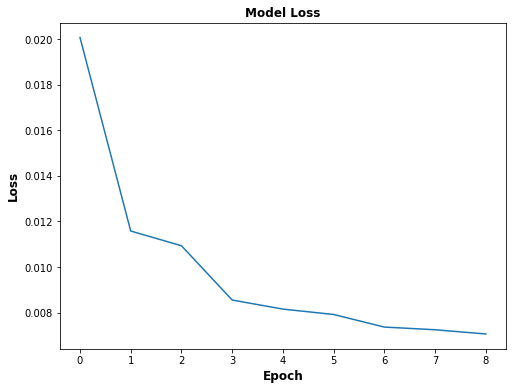

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss', weight = 'bold')
plt.ylabel('Loss', weight = 'bold', fontsize = 12)
plt.xlabel('Epoch', weight = 'bold', fontsize = 12)

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
print("Mean Absolute Error: ", mean_absolute_error(preds, y_test))

Mean Absolute Error:  0.03350376779843165


In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

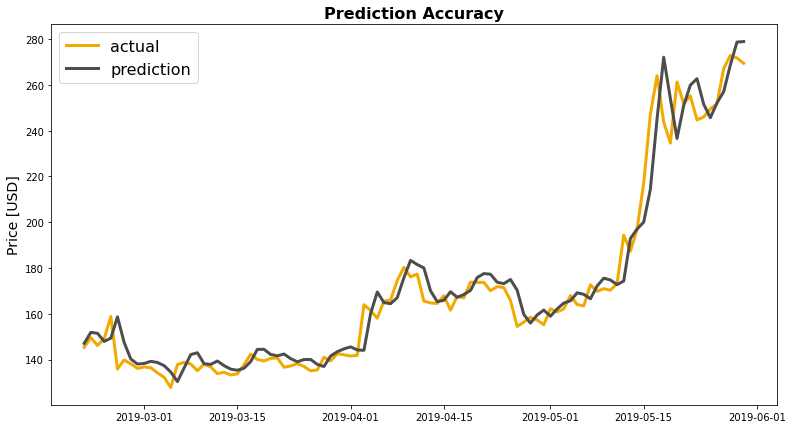

In [ ]:
line_plot(targets[:100], preds[:100], 'actual', 'prediction', title = "Prediction Accuracy", lw=3)

In [ ]:
#Compare MSE By Window Length
length = [5, 10, 15, 20, 30]

mse = []

for i in length:
    mse.append(window_model(i))

Epoch 1/10
75/75 [==============================] - 2s 6ms/step - loss: 0.0040
Epoch 2/10
75/75 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 3/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0024
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0022
Epoch 5/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 6/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0021
Epoch 7/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 8/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 9/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 10/10
75/75 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 1/10
75/75 [==============================] - 3s 10ms/step - loss: 0.0060
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.0035
Epoch 3/10
75/75 [==============================]

Text(0.5, 1.0, 'MSE vs. Window Length')

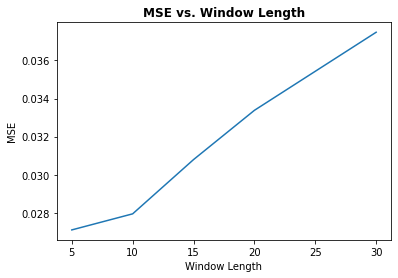

In [ ]:
plt.plot(length, mse)
plt.ylabel("MSE")
plt.xlabel("Window Length")
plt.title("MSE vs. Window Length", weight = 'bold')